# Real time Twitter Sentiment Analysis with PySpark

I ran this notebook first on google colab then imported it to Kaggle.

## Install required packages and libraries

In [1]:
!pip install pyspark
#!pip install kaggle
#!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=abb0321e40c289c9e6c89a954ff3a3b91ed5e2ed7dcd2d9771c38bed05c59147
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


## Import the required packages and libraries

In [2]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
import nltk

## Load the Data from Kaggle

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


## Start the Spark session 

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Twitter').getOrCreate()
spark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/05 13:23:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading the data in Spark Dataframe

In [5]:
#df = spark.read.csv('filename.csv', header = True, inferSchema = True)
df = spark.read.csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", inferSchema=True)

In [6]:
df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  0|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

#### Renaming the columns

In [7]:
df = df.withColumnRenamed('_c0','target').withColumnRenamed('_c1','id').withColumnRenamed('_c2','date')\
  .withColumnRenamed('_c3','flag').withColumnRenamed('_c4','user').withColumnRenamed('_c5','text')
df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

#### Checking the Schema

In [8]:
df.printSchema() 

root
 |-- target: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



## Inspect and Preprocessing the Dataset

In [9]:
df.head(5)

[Row(target=0, id=1467810369, date='Mon Apr 06 22:19:45 PDT 2009', flag='NO_QUERY', user='_TheSpecialOne_', text="@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"),
 Row(target=0, id=1467810672, date='Mon Apr 06 22:19:49 PDT 2009', flag='NO_QUERY', user='scotthamilton', text="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(target=0, id=1467810917, date='Mon Apr 06 22:19:53 PDT 2009', flag='NO_QUERY', user='mattycus', text='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 Row(target=0, id=1467811184, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='ElleCTF', text='my whole body feels itchy and like its on fire '),
 Row(target=0, id=1467811193, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='Karoli', text="@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because

In [10]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1600000 rows and  6 columns in the dataset.


#### Check for missing values!!

In [11]:
df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,target,id,date,flag,user,text
0,0,0,0,0,0,0


There are no missing values in the dataset.

#### Check for duplicates!!

In [12]:
df = df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1600000


There are no duplicates in the dataset.

#### Check types of columns!!

In [13]:
df.dtypes

[('target', 'int'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('flag', 'string'),
 ('user', 'string'),
 ('text', 'string')]

#### Summary of the Dataframe

In [14]:
#df.summary().show()
#df.describe().show()

We only need the target and the text column for sentiment analyses, that's why dropping the rest of the columns.

In [15]:
drop_cols= ("id","date","flag","user")
df = df.drop(*drop_cols)

In [16]:
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- text: string (nullable = true)



In [17]:
df.show(5, truncate = False)

+------+----------------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                        |
+------+----------------------------------------------------------------------------------------------------------------------------+
|0     |At work                                                                                                                     |
|0     |@astewart87 oh my gosh that made me emotional haha idk why!!! i dont want to get old                                        |
|0     |i need new glasses...mines is hangnon 1 arm                                                                                 |
|0     |Getting changed in the hopes that, that means we can go to the store now!  Poor cat is out of food...oops.                  |
|0     |really now, time for sleep. dreaming of my city, more 

In [18]:
df.select("target").distinct().show()

+------+
|target|
+------+
|     0|
|     4|
+------+



There are only two distinct values in target column. O for "Negative" and 4 for "Positive" according to data description. Let's change the value of Positive from 4 to 1.

In [19]:
df.createOrReplaceTempView('temp')
df = spark.sql('SELECT CASE target WHEN 4 THEN 1.0  ELSE 0 END AS label, text FROM temp')
df.show(5, truncate = False)

+-----+----------------------------------------------------------------------------------------------------------------------------+
|label|text                                                                                                                        |
+-----+----------------------------------------------------------------------------------------------------------------------------+
|0.0  |At work                                                                                                                     |
|0.0  |@astewart87 oh my gosh that made me emotional haha idk why!!! i dont want to get old                                        |
|0.0  |i need new glasses...mines is hangnon 1 arm                                                                                 |
|0.0  |Getting changed in the hopes that, that means we can go to the store now!  Poor cat is out of food...oops.                  |
|0.0  |really now, time for sleep. dreaming of my city, more tattoos,

In [20]:
df.tail(5)

[Row(label=Decimal('1.0'), text='Installing office to my little netbook, going to do some work at a friends house in a short while. '),
 Row(label=Decimal('1.0'), text='man.. Ab got work.. ahhh!!! but later imma shop till i drop!! '),
 Row(label=Decimal('1.0'), text="@paupaula I'm joining The SPectrum maybe. Idk... But yeah I'm dedicating myself to my studies too  How? Idk."),
 Row(label=Decimal('1.0'), text='Friend over  My god! 300th Update!!'),
 Row(label=Decimal('1.0'), text='TIME MAG ONLINE is very interesting. Watching videos this morning. Enjoying free content... while it lasts. ')]

In [21]:
df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|800000|
|  1.0|800000|
+-----+------+



## Text Preprocessing

#### Remove stopwords, punctuations, links, and stem the data

In [22]:
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [23]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [25]:
%%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: user 5.66 ms, sys: 2.37 ms, total: 8.03 ms
Wall time: 47.7 ms


In [26]:
df.show()

+-----+--------------------+--------------------+
|label|                text|        text_cleaned|
+-----+--------------------+--------------------+
|  0.0|            At work |                work|
|  0.0|@astewart87 oh my...|oh gosh made emot...|
|  0.0|i need new glasse...|need new glasses ...|
|  0.0|Getting changed i...|getting changed h...|
|  0.0|really now, time ...|really time sleep...|
|  0.0|pfff i want to go...|pfff want go back...|
|  0.0|Currently watchin...|currently watchin...|
|  0.0|What a bad day! N...|bad day need comf...|
|  0.0|Tried to install ...|tried install twi...|
|  0.0|Having casual, un...|casual unprotecte...|
|  0.0|Good morning worl...|good morning worl...|
|  0.0|@pmarnandus re: d...|daily gossip well...|
|  0.0|Someone somewhere...|someone somewhere...|
|  0.0|@weblivz What a b...|boot would demand...|
|  0.0|@jobeaz damn, sor...|damn sorry missed...|
|  0.0|@klariza that's a...|awesome love stuf...|
|  0.0|my tv husbands ri...|tv husbands rick ...|


In [27]:
df = df.drop("text")

## Displaying Word Cloud

In [28]:
from wordcloud import WordCloud

In [29]:
pandas_df = df.toPandas()
pandas_df.head()

,label,text_cleaned
0,0.0,work
1,0.0,oh gosh made emotional haha idk dont want get old
2,0.0,need new glasses mines hangnon 1 arm
3,0.0,getting changed hopes means go store poor cat ...
4,0.0,really time sleep dreaming city tattoos great ...


#### Positive Sentiments Word Cloud

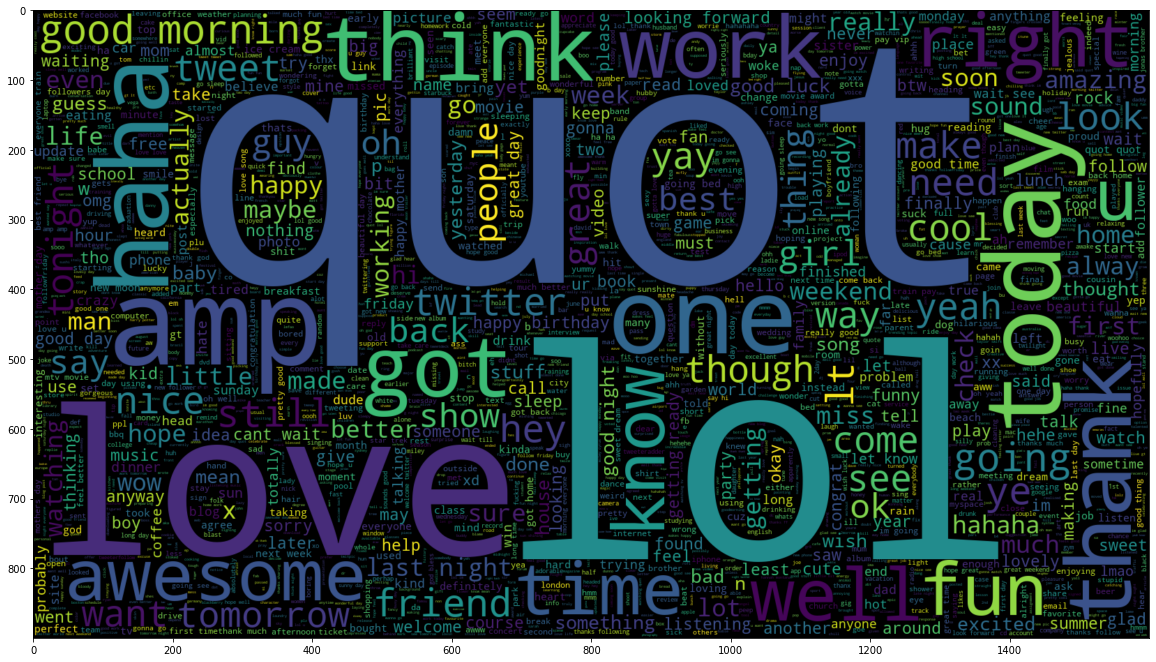

In [30]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==1.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Negative Sentiments Word Cloud

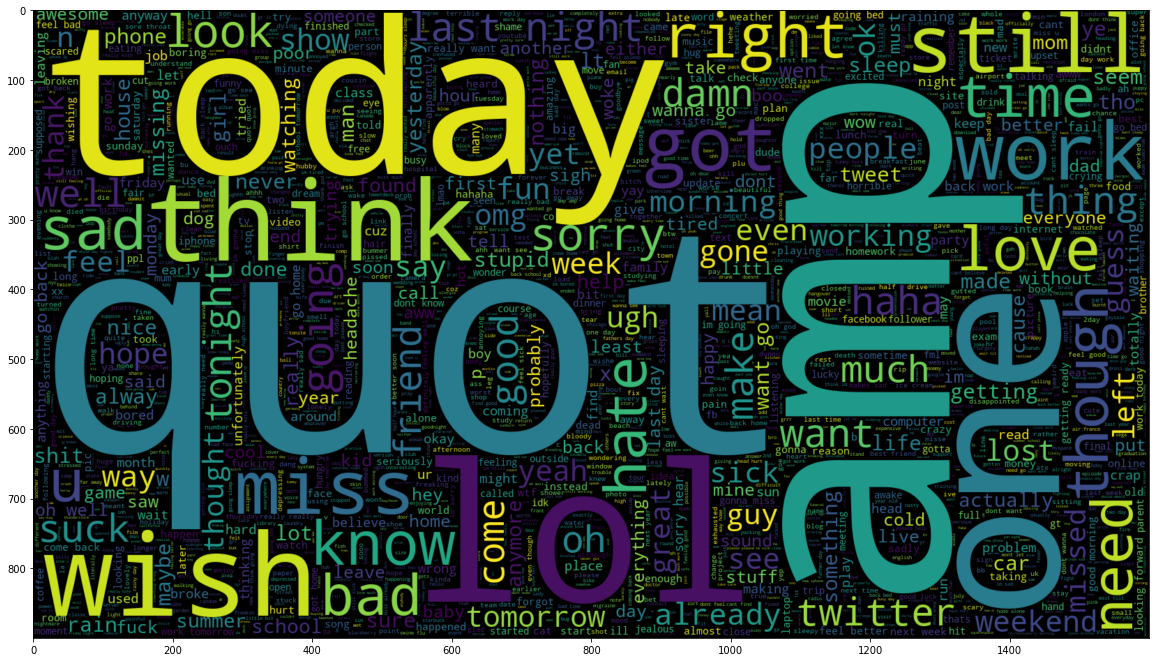

In [31]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==0.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Preparing Data for Model Building

#### Tokenizing the Text

In [32]:
from pyspark.ml.feature import Tokenizer

In [33]:
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_tokens")
words_tokens = tokenizer.transform(df)
words_tokens.show()

+-----+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|
+-----+--------------------+--------------------+
|  0.0|                work|              [work]|
|  0.0|oh gosh made emot...|[oh, gosh, made, ...|
|  0.0|need new glasses ...|[need, new, glass...|
|  0.0|getting changed h...|[getting, changed...|
|  0.0|really time sleep...|[really, time, sl...|
|  0.0|pfff want go back...|[pfff, want, go, ...|
|  0.0|currently watchin...|[currently, watch...|
|  0.0|bad day need comf...|[bad, day, need, ...|
|  0.0|tried install twi...|[tried, install, ...|
|  0.0|casual unprotecte...|[casual, unprotec...|
|  0.0|good morning worl...|[good, morning, w...|
|  0.0|daily gossip well...|[daily, gossip, w...|
|  0.0|someone somewhere...|[someone, somewhe...|
|  0.0|boot would demand...|[boot, would, dem...|
|  0.0|damn sorry missed...|[damn, sorry, mis...|
|  0.0|awesome love stuf...|[awesome, love, s...|
|  0.0|tv husbands rick ...|[tv, husbands, ri...|


#### Applying CountVectorizer

In [34]:
from pyspark.ml.feature import CountVectorizer

In [35]:
count = CountVectorizer (inputCol="words_tokens", outputCol="rawFeatures")
model = count.fit(words_tokens)
featurizedData = model.transform(words_tokens)
featurizedData.show()


22/08/05 13:28:54 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


+-----+--------------------+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|         rawFeatures|
+-----+--------------------+--------------------+--------------------+
|  0.0|                work|              [work]|  (262144,[7],[1.0])|
|  0.0|oh gosh made emot...|[oh, gosh, made, ...|(262144,[2,26,30,...|
|  0.0|need new glasses ...|[need, new, glass...|(262144,[25,33,10...|
|  0.0|getting changed h...|[getting, changed...|(262144,[4,56,235...|
|  0.0|really time sleep...|[really, time, sl...|(262144,[12,18,35...|
|  0.0|pfff want go back...|[pfff, want, go, ...|(262144,[4,6,13,2...|
|  0.0|currently watchin...|[currently, watch...|(262144,[5,32,61,...|
|  0.0|bad day need comf...|[bad, day, need, ...|(262144,[1,33,48,...|
|  0.0|tried install twi...|[tried, install, ...|(262144,[7,39,121...|
|  0.0|casual unprotecte...|[casual, unprotec...|(262144,[20,81,20...|
|  0.0|good morning worl...|[good, morning, w...|(262144,[0,10,35,...|
|  0.0

#### Applying Term Frequency - Inverse Document Frequency (TF-IDF)

In [36]:
from pyspark.ml.feature import IDF

In [37]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show()  

22/08/05 13:29:01 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/05 13:29:47 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[7],[3.24...|
|  0.0|(262144,[2,26,30,...|
|  0.0|(262144,[25,33,10...|
|  0.0|(262144,[4,56,235...|
|  0.0|(262144,[12,18,35...|
|  0.0|(262144,[4,6,13,2...|
|  0.0|(262144,[5,32,61,...|
|  0.0|(262144,[1,33,48,...|
|  0.0|(262144,[7,39,121...|
|  0.0|(262144,[20,81,20...|
|  0.0|(262144,[0,10,35,...|
|  0.0|(262144,[24,39,40...|
|  0.0|(262144,[3,147,98...|
|  0.0|(262144,[15,49,29...|
|  0.0|(262144,[21,51,14...|
|  0.0|(262144,[8,31,78,...|
|  0.0|(262144,[66,201,3...|
|  0.0|(262144,[8,31,124...|
|  0.0|(262144,[157,256,...|
|  0.0|(262144,[176,317,...|
+-----+--------------------+
only showing top 20 rows



In [38]:
df_final = rescaledData.select("label", "features")# We want only the label and features columns for our machine learning models

#### Splitting the data into training and test dataset

In [39]:
seed = 42  # set seed for reproducibility

trainDF, testDF = df_final.randomSplit([0.7,0.3],seed)

In [40]:
trainDF.count()

22/08/05 13:29:54 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


1119906

In [41]:
trainDF.show()

22/08/05 13:30:47 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


+-----+--------------+
|label|      features|
+-----+--------------+
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
+-----+--------------+
only showing top 20 rows



In [42]:
trainDF.groupby("label").count().show()

22/08/05 13:31:13 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:31:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/05 13:31:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/05 13:31:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/05 13:31:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/05 13:31:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/05 13:31:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/05 13:31:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/05 13:31:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/05 13:31:54 WARN RowBasedKeyValueBatch: Calling spill() on

22/08/05 13:32:00 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
+-----+------+
|label| count|
+-----+------+
|  0.0|559802|
|  1.0|560104|
+-----+------+



In [43]:
testDF.count()

22/08/05 13:32:05 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


480094

## Training the Model

In [44]:
from pyspark.ml.classification import LogisticRegression

In [45]:
lr = LogisticRegression(labelCol = "label", featuresCol = "features",maxIter = 10)
model = lr.fit(trainDF)

22/08/05 13:32:59 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:33:49 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:36 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/08/05 13:34:36 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/08/05 13:34:36 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:37 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:38 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:39 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:41 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:42 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:43 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:45 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:46 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/05 13:34:47 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


In [46]:
predictions = model.transform(testDF)

In [47]:
pred = predictions.toPandas()
pred.head()

22/08/05 13:35:05 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


,label,features,rawPrediction,probability,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26890911418749947, 0.26890911418749947]","[0.43317492548725295, 0.566825074512747]",1.0
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26890911418749947, 0.26890911418749947]","[0.43317492548725295, 0.566825074512747]",1.0
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26890911418749947, 0.26890911418749947]","[0.43317492548725295, 0.566825074512747]",1.0
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26890911418749947, 0.26890911418749947]","[0.43317492548725295, 0.566825074512747]",1.0
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26890911418749947, 0.26890911418749947]","[0.43317492548725295, 0.566825074512747]",1.0


## Evaluating the Model

In [48]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [49]:
evaluator = BinaryClassificationEvaluator(labelCol = "label", metricName='areaUnderROC')

In [50]:
areaUnderROC = evaluator.evaluate(predictions)
print(f"The testing areaUnderROC of our Logistic Regression model is: {areaUnderROC}")

22/08/05 13:36:42 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


The testing areaUnderROC of our Logistic Regression model is: 0.8172652586179128


#### Classification Report and Confusion Matrix

In [51]:
y_true = pred['label'].astype('float')
y_pred = pred['prediction']

In [52]:
y_true.value_counts()

0.0    240198
1.0    239896
Name: label, dtype: int64

In [53]:
y_pred.value_counts()

1.0    247095
0.0    232999
Name: prediction, dtype: int64

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76    240198
         1.0       0.75      0.77      0.76    239896

    accuracy                           0.76    480094
   macro avg       0.76      0.76      0.76    480094
weighted avg       0.76      0.76      0.76    480094



<AxesSubplot:>

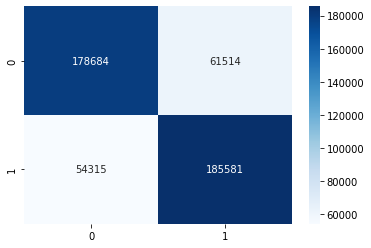

In [55]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt=  'd', cmap = 'Blues')